In [1]:
from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)
images_torch = torch.from_numpy(np.array(images))

In [3]:
directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

In [29]:
def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    downsample = cpnet.downsample(x)

    downsample_return = downsample[1].squeeze(0)
    downsample_return = downsample_return.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(downsample_return):
        downsample_return[k] = cv2.resize(np.array(image), dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
    downsample_return = np.array(downsample_return)
    downsample_return = torch.from_numpy(downsample_return)

    style = cpnet.make_style(downsample[-1])
    upsample = cpnet.upsample(style, downsample, cpnet.mkldnn)

    output = cpnet.output(upsample)
    output = output.squeeze(0)
    output = output[2]
    
    print(output.shape)
    output = output.cpu().detach().numpy().tolist()
    output = cv2.resize(np.array(output), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    output = np.array(output)
    output = torch.from_numpy(output)

    upsample = upsample.squeeze(0)
    upsample = upsample.cpu().detach().numpy().tolist()
    for (k, image) in enumerate(upsample):
        upsample[k] = cv2.resize(np.array(image), dsize=(512, 512), interpolation=cv2.INTER_NEAREST)
    upsample = np.array(upsample)
    upsample = torch.from_numpy(upsample)

    return downsample_return, upsample, output

In [30]:
downsample_return, upsample, output = get_pre_activations(images[0],cpnet)

print(downsample_return.shape, upsample.shape, output.shape)

torch.Size([536, 536])
torch.Size([64, 256, 256]) torch.Size([32, 512, 512]) torch.Size([512, 512])


In [8]:
unet = UNet(nbClasses=1)
unet = unet.to('cuda:0')

encFeatures, decFeatures, map = unet(torch.from_numpy(images[0]).unsqueeze(0).unsqueeze(0).to('cuda:0'))

In [18]:
print(encFeatures[2].shape)

torch.Size([1, 64, 256, 256])


In [26]:
cp_upsamples = []
cp_outputs = []
for image in images:
    upsample, output = get_pre_activations(image,cpnet)
    print('upsample shape',upsample.shape)
    print('output shape',output.shape)
    cp_upsamples.append(upsample)
    cp_outputs.append(output)

upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])
upsample shape torch.Size([32, 512, 512])
output shape torch.Size([512, 512])


In [99]:
class ImageDataset(Dataset):
    def __init__(self, image, cellprob, cellmask):
        self.image = image
        self.cellprob = cellprob
        self.cellmask = cellmask

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        cellprob = self.cellprob[idx]
        cellmask = self.cellmask[idx]
        return img, cellprob, cellmask


images_torch_rotated = []
for image in images_torch:
    images_torch_rotated.append(image)
    for i in range(3):
        image = torch.rot90(image, 1, [0, 1])
        images_torch_rotated.append(image)

images_torch_rotated_flipped = []
for image in images_torch_rotated:
    images_torch_rotated_flipped.append(image)
    images_torch_rotated_flipped.append(torch.flip(image, [1]))

cp_upsamples_rotated = []
for upsample in cp_upsamples:
    cp_upsamples_rotated.append(upsample)
    for i in range(3):
        upsample = torch.rot90(upsample, 1, [1, 2])
        cp_upsamples_rotated.append(upsample)

cp_upsamples_rotated_flipped = []
for upsample in cp_upsamples_rotated:
    cp_upsamples_rotated_flipped.append(upsample)
    cp_upsamples_rotated_flipped.append(torch.flip(upsample, [2]))

cp_outputs_rotated = []
for output in cp_outputs:
    cp_outputs_rotated.append(output)
    for i in range(3):
        output = torch.rot90(output, 1, [0, 1])
        cp_outputs_rotated.append(output)

cp_outputs_rotated_flipped = []
for output in cp_outputs_rotated:
    cp_outputs_rotated_flipped.append(output)
    cp_outputs_rotated_flipped.append(torch.flip(output, [1]))

train_dataset = ImageDataset(images_torch, cp_upsamples, cp_outputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

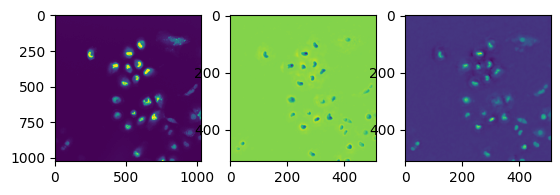

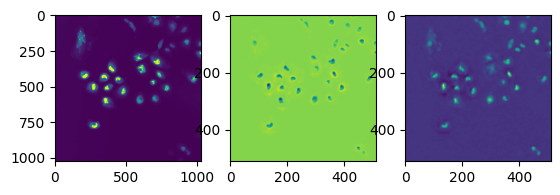

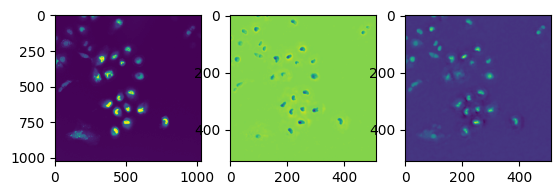

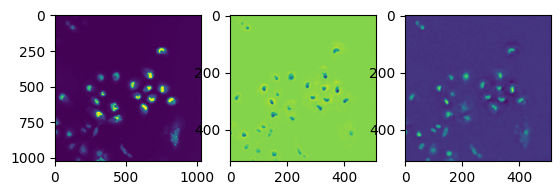

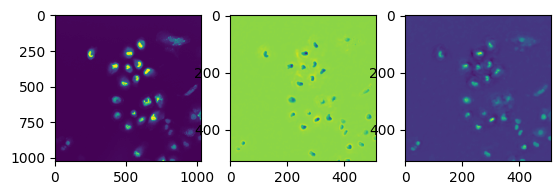

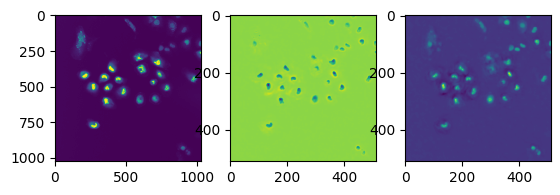

KeyboardInterrupt: 

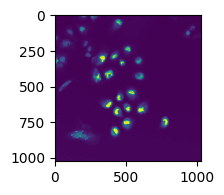

In [101]:
for i in range(len(images_torch_rotated)):
    plt.subplot(1,3,1)
    plt.imshow(images_torch_rotated[i])
    plt.subplot(1,3,2)
    plt.imshow(cp_upsamples_rotated[i][10])
    plt.subplot(1,3,3)
    plt.imshow(cp_outputs_rotated[i])
    plt.show()

In [124]:
class KDLoss(torch.nn.Module):
    def __init__(self, alpha = 1.0, beta = 1.0, temperature=1):
        super(KDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

    def forward(self, y_32_pred, y_3_pred, y_32_true, y_3_true):

        y_32_pred = F.sigmoid(y_32_pred)
        y_32_true = F.sigmoid(y_32_true)
        y_32_loss = F.mse_loss(y_32_pred, y_32_true.float())

        y_3_pred = F.sigmoid(y_3_pred)
        y_3_true = F.sigmoid(y_3_true)
        y_3_loss = F.mse_loss(y_3_pred, y_3_true.float())

        loss = self.alpha * y_32_loss + self.beta * y_3_loss
        return loss

In [125]:
def trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler, epoch_num):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, upsample, cp_output in train_loader:
        (image,upsample,cp_output) = (image.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0')) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        y_32_pred, y_3_pred = unet(image)
        y_32_pred = y_32_pred.squeeze(1)
        y_3_pred = y_3_pred.squeeze(1)
        
        #pred, predicted_masks, cellprob, cellmask = pred.squeeze(0), predicted_masks.float().squeeze(0), cellprob.squeeze(0), cellmask.squeeze(0)

        loss = loss_fn(y_32_pred, y_3_pred, upsample, cp_output) # calculate the loss of that prediction

        train_loss += loss
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)

    return unet

In [126]:
unet = UNet(nbClasses=1)
unet = unet.to('cuda:0')
loss_fn = KDLoss()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.00001, max_lr=0.1)

for epoch in range(200):
    unet = trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch)

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch  0 Training loss:  0.33968305587768555 Time:  1.3227965831756592
Epoch  1 Training loss:  0.33627995577725495 Time:  1.081894874572754
Epoch  2 Training loss:  0.32764720916748047 Time:  1.0717828273773193
Epoch  3 Training loss:  0.31415980512445624 Time:  1.079721212387085
Epoch  4 Training loss:  0.29671441424976697 Time:  1.079481601715088
Epoch  5 Training loss:  0.27591453899036755 Time:  1.0852510929107666
Epoch  6 Training loss:  0.2516834952614524 Time:  1.0778257846832275
Epoch  7 Training loss:  0.22243220155889337 Time:  1.080010175704956
Epoch  8 Training loss:  0.18564822457053445 Time:  1.0857229232788086
Epoch  9 Training loss:  0.14996406165036288 Time:  1.0916929244995117
Epoch  10 Training loss:  0.13619996200908313 Time:  1.091064691543579
Epoch  11 Training loss:  0.12821417505090887 Time:  1.0861117839813232
Epoch  12 Training loss:  0.11928103186867454 Time:  1.0943076610565186
Epoch  13 Training loss:  0.11128149249336937 Time:  1.093050479888916
Epoch  14

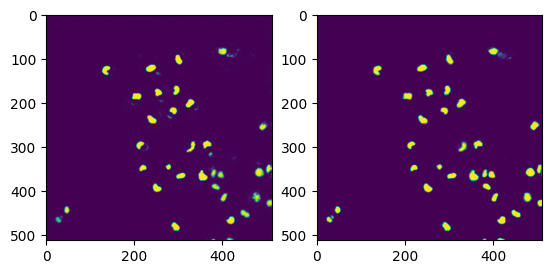

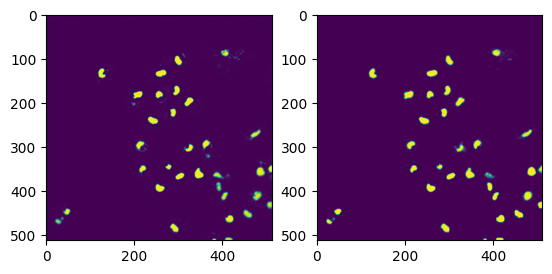

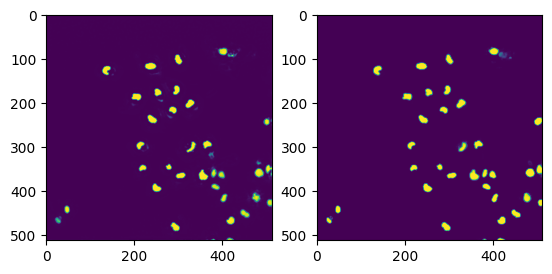

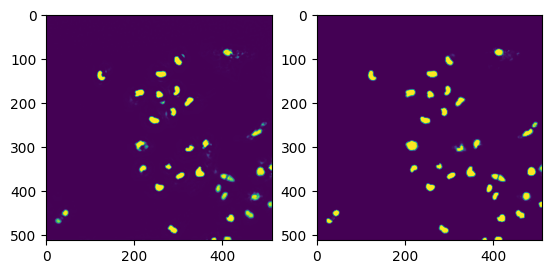

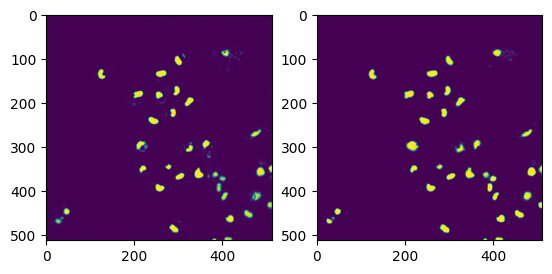

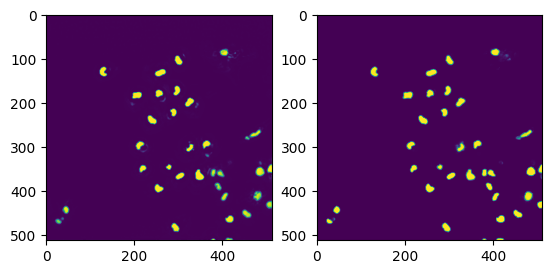

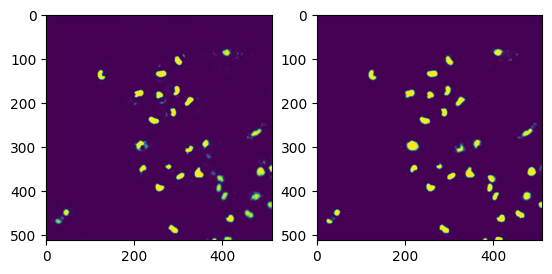

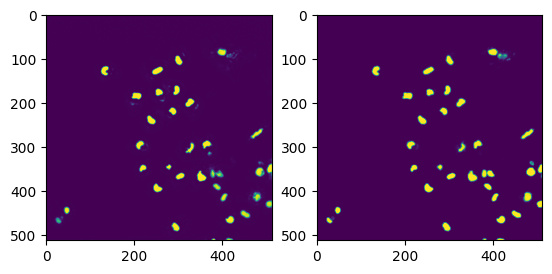

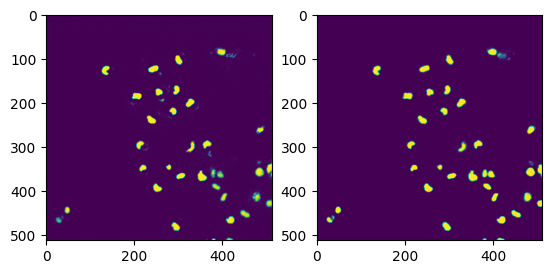

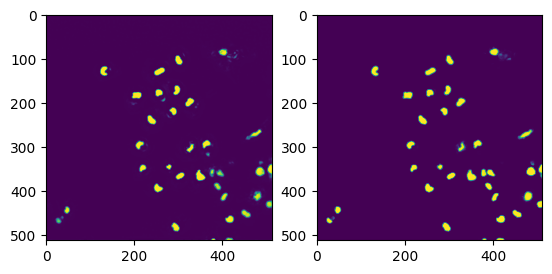

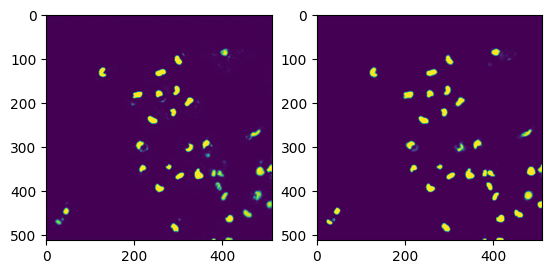

In [127]:
for image, upsample, cp_output in train_loader:
    (image,upsample,cp_output) = (image.to('cuda:0'),upsample.to('cuda:0'),cp_output.to('cuda:0')) # sending the data to the device (cpu or GPU)

    image = image.unsqueeze(1)
    unet = unet.to('cuda:0')
    y_32_pred, y_3_pred = unet(image)

    y_3_pred = F.sigmoid(y_3_pred)
    y_3_pred = y_3_pred.cpu().detach().numpy()
    y_3_pred = y_3_pred.squeeze(0)

    cp_output = cp_output[0]
    cp_output = F.sigmoid(cp_output)
    cp_output = cp_output.cpu().detach().numpy()

    plt.subplot(1,2,1)
    plt.imshow(y_3_pred[0])
    plt.subplot(1,2,2)
    plt.imshow(cp_output)
    plt.show()

In [106]:
print(y_3_pred)
print(cp_output)

[[[0.06693971 0.03253898 0.03053929 ... 0.02634328 0.02927858 0.05937618]
  [0.03434773 0.01169475 0.01076066 ... 0.00831075 0.01010595 0.03287454]
  [0.03572445 0.01318434 0.01259985 ... 0.00986714 0.0125111  0.03924665]
  ...
  [0.03153482 0.01080992 0.00998604 ... 0.00754963 0.00981235 0.03301989]
  [0.03583304 0.01327807 0.01258911 ... 0.00994233 0.01240526 0.03742411]
  [0.07073487 0.03781565 0.03731294 ... 0.03195206 0.03612169 0.07205671]]]
[[0.00029631 0.0003395  0.00041257 ... 0.00035064 0.00038027 0.00028118]
 [0.0003047  0.00021477 0.00039552 ... 0.00036496 0.00030415 0.00025971]
 [0.00028868 0.00015494 0.000301   ... 0.00032261 0.00027816 0.00024756]
 ...
 [0.00021065 0.00015146 0.00039156 ... 0.00028084 0.00027147 0.00022346]
 [0.00021234 0.0001446  0.00045609 ... 0.00030755 0.00028479 0.00024   ]
 [0.00025197 0.00014878 0.00019071 ... 0.00020334 0.00019635 0.00019057]]


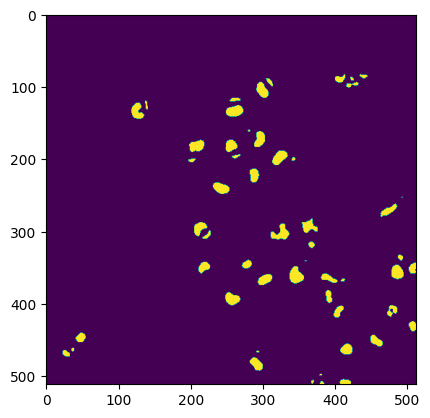

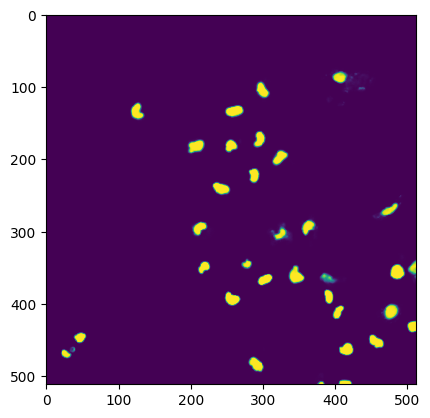

In [115]:
y_3_pred_0 = y_3_pred[0]
y_3_pred_bin = np.where(y_3_pred_0 > 0.4, 1, 0)
plt.imshow(y_3_pred_bin)
plt.show()

plt.imshow(cp_output)
plt.show()

In [ ]:
from cellpose import dynamics

dynamics.get_masks(y_3_pred)

In [ ]:
#sigmoid numpy array y_3_pred
y_3_pred_2_sig = 1/(1+np.exp(-y_3_pred[2]))
print(np.unique(y_3_pred_2_sig))
y_3_pred_2_sig_binary = np.where(y_3_pred_2_sig>0.1,1,0)
print(np.unique(y_3_pred_2_sig_binary))
plt.imshow(y_3_pred_2_sig_binary)
plt.show()

In [ ]:
unet = UNet(nbClasses=3)
decfeatures, pred = unet(torch.from_numpy(images[0]).unsqueeze(0).unsqueeze(0))
print(decfeatures.shape, pred.shape)